# Session 4: Final Activity

Immanuel Williams & Ciera Millard  
2025-07-10

## Session 4: Final Activity

### 1. Weather Activity

Now that we have worked with HTML elements and API calls, let’s put
these skills together to create a **weather map of Iowa counties** based
on the maximum temperature at each county’s administrative seat (county
seat).

<figure>
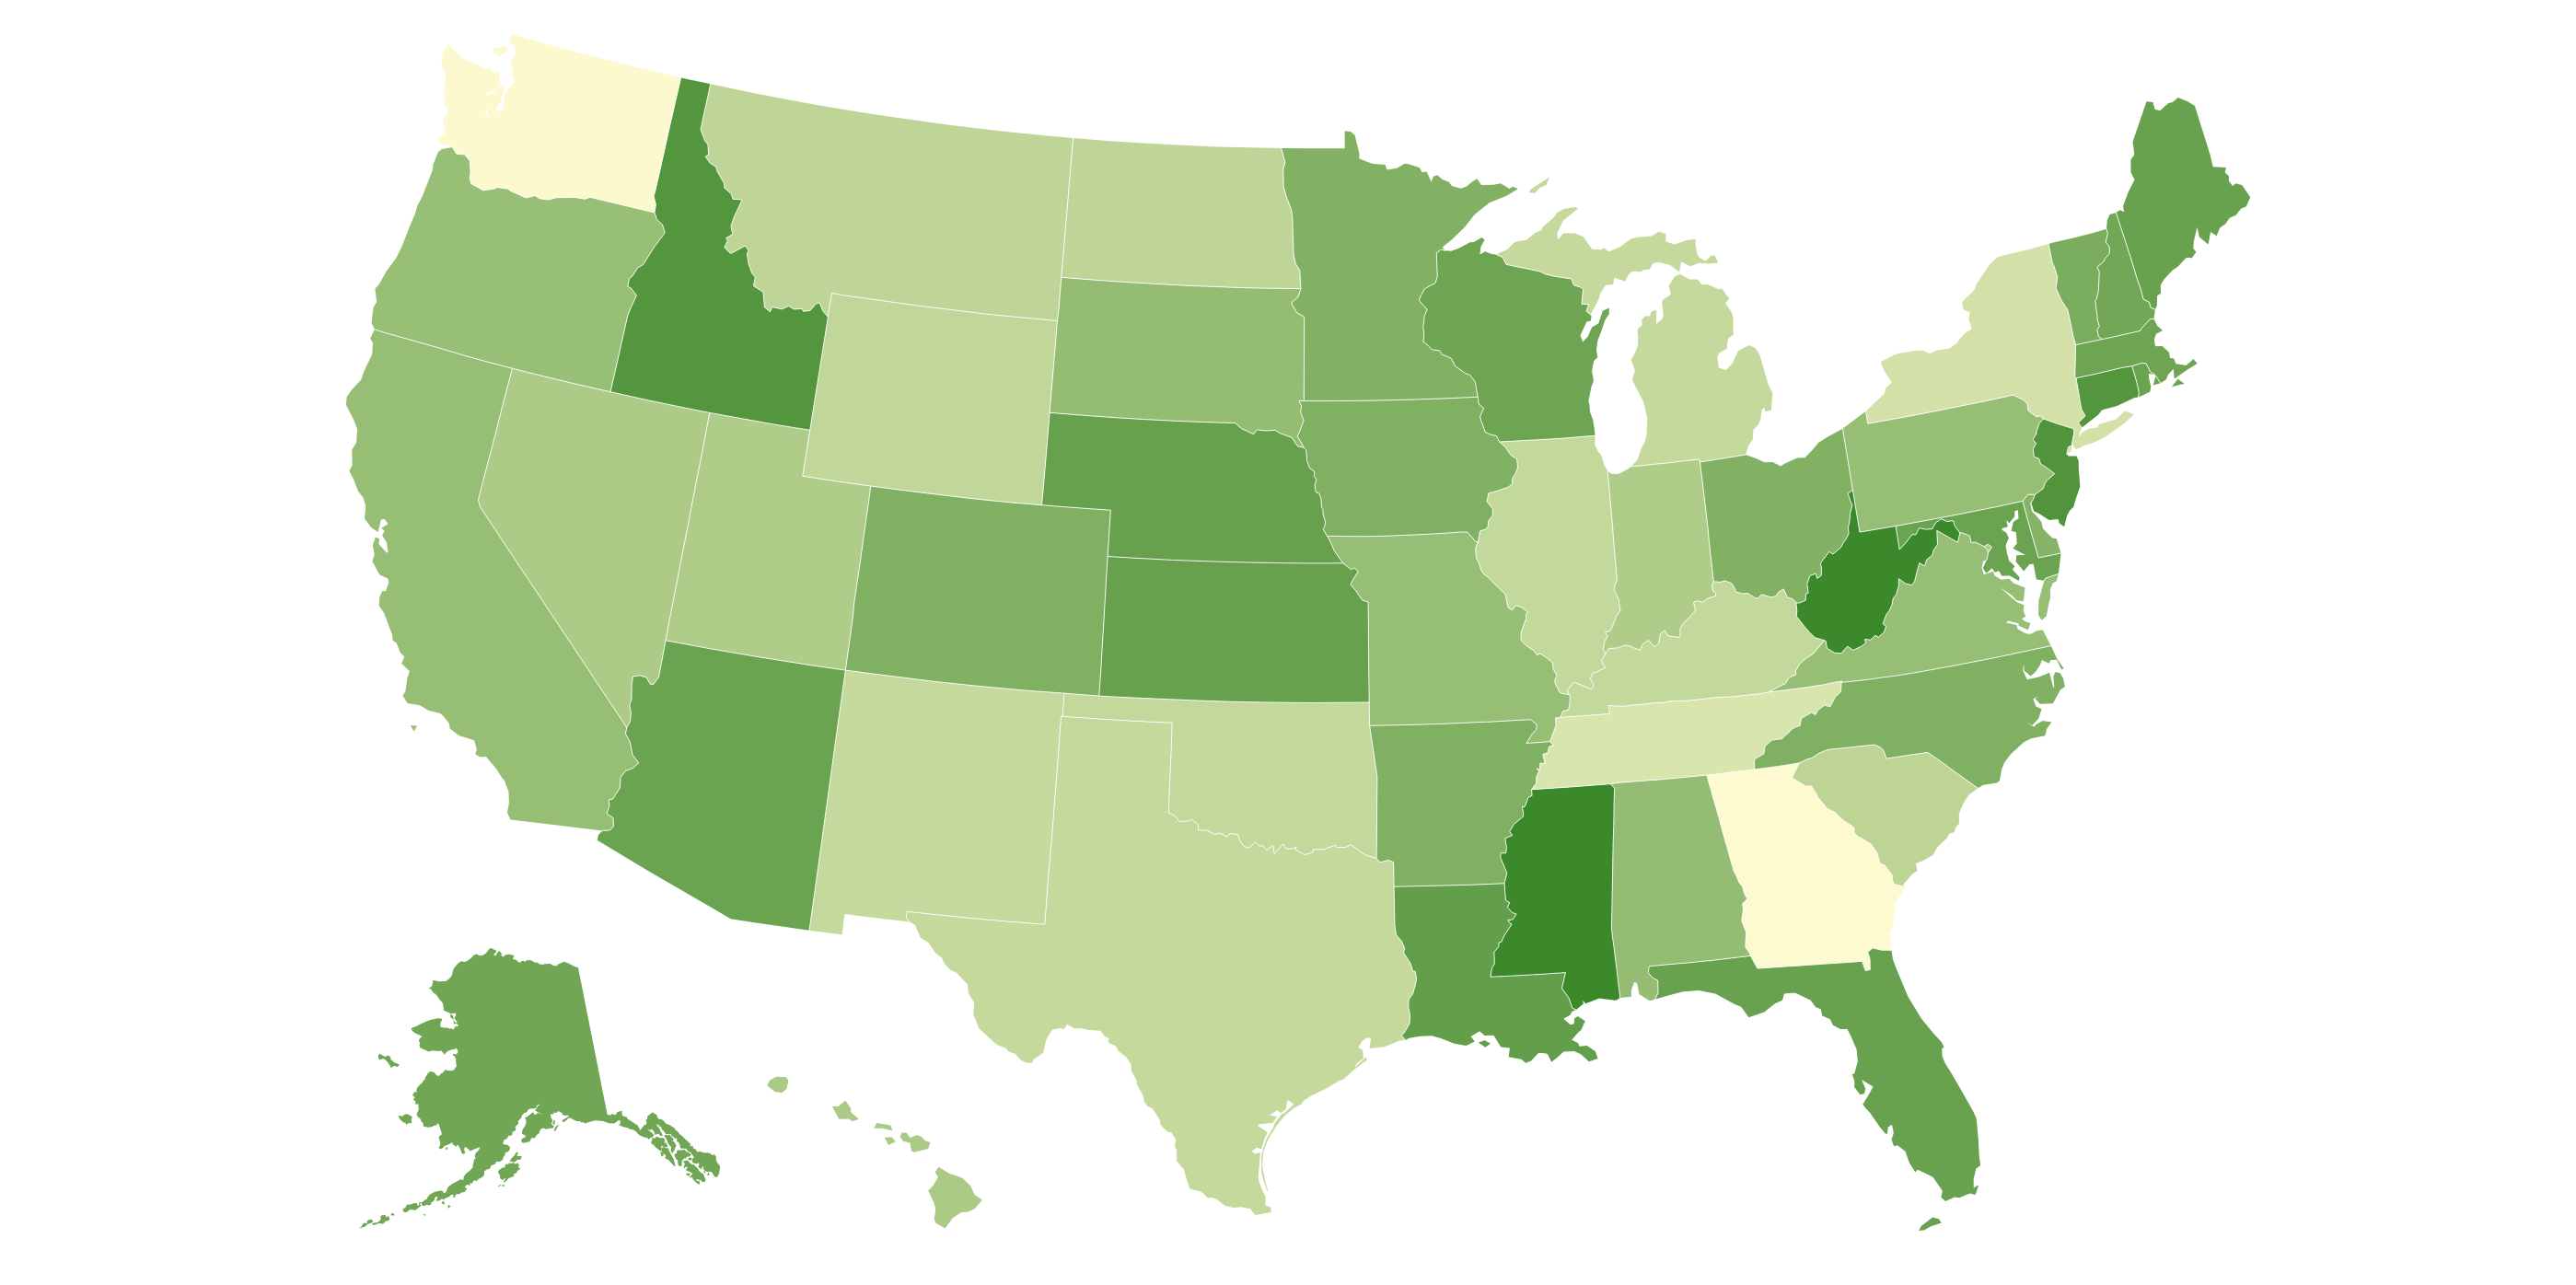
<figcaption aria-hidden="true">Chloropleth Map
(geoapify.com)</figcaption>
</figure>

------------------------------------------------------------------------

#### Step 1: Load Libraries

We’ll begin by loading the libraries necessary for data manipulation,
API calls, and visualization.

In [ ]:
# Step 1: Load Libraries
# Step 1a: General utilities
library(httr2)       # Makes web requests
library(tibble)      # Easier and prettier data frames
library(lubridate)   # Handles dates
library(ggplot2)     # Data visualization
library(dplyr)       # Data manipulation
library(dotenv)      # Loads environment variables from .Renviron
library(glue)        # Easier string concatenation
library(purrr)       # Functional programming tools
library(rvest)       # Web scraping
library(tigris)      # U.S. shapefiles for mapping
library(stringr)     # String manipulation and handling

In [ ]:
# Step 1b: Load API key from .Renviron.txt
dotenv::load_dot_env(file = ".Renviron.txt")

------------------------------------------------------------------------

#### Step 2: Extract County and Seat Information from Wikipedia

Here we extract a table from Wikipedia listing all Iowa counties and
their corresponding county seats.

In [ ]:
# Step 2: Scrape HTML Table from Wikipedia
# Step 2a: Set URL
url <- "https://en.wikipedia.org/wiki/List_of_counties_in_Iowa"

# Step 2b: Read HTML
webpage <- url |>  
  rvest::read_html()

# Step 2c: Extract all HTML tables from the page
html_tables <- webpage |> 
  rvest::html_table()

# Step 2d: Select the correct table (based on inspection)
table1 <- html_tables |> 
  purrr::pluck(2)

# Step 2e: Clean and prepare county seat names
#         Add ', IA, USA' to ensure geolocation works with OpenWeather API
#         Use only the first County Seat city name when mulitple exist
county_seats_df <- table1 |> 
  mutate(
    `County seat[4]` = str_split(`County seat[4]`, " and ") |> sapply(`[`, 1),
    city = paste0(`County seat[4]`, ", IA, USA")
  )

*Discussion: Why would we need to append”, IA, USA” to the city name?*  
*What would happen if we do not?*

A: This helps geocoding APIs return accurate coordinates. (Just “Ames”
returns a rural town of 600 in Northern France)

<figure>
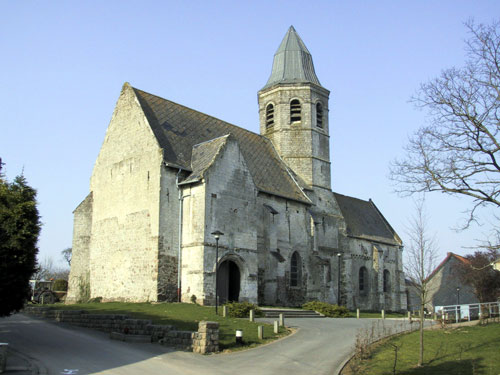
<figcaption aria-hidden="true">Not Exactly Ames, IA, USA. Church of
Ames, France (Wikipedia)</figcaption>
</figure>

------------------------------------------------------------------------

#### Step 3: Pull Weather Data for Each County Seat

We now define a function to call the OpenWeather Geocoding and One Call
APIs. Then we use it to retrieve temperature data for each city.

In [ ]:
# Step 3: Define function to get geocoded weather data from OpenWeather
get_city_weather <- function(city, date = Sys.Date()) {
  # Step 3a: Get coordinates from geocoding API
  geo_url <- glue(
    "http://api.openweathermap.org/geo/1.0/direct?",
    "q=", URLencode(city),
    "&limit=1&appid=", Sys.getenv("API_KEY"))
  geo_response <- req_perform(request(geo_url))

  if (resp_status(geo_response) == 200) {
    geo_data <- as.data.frame(resp_body_json(geo_response))
    if (nrow(geo_data) == 0) return(NULL)

    lat <- geo_data$lat
    lon <- geo_data$lon

    # Step 3b: Call the weather summary API
    weather_url <- glue(
      "https://api.openweathermap.org/data/3.0/onecall/day_summary?",
      "lat=", lat,
      "&lon=", lon,
      "&date=", format(date, "%Y-%m-%d"),
      "&appid=", Sys.getenv("API_KEY"),
      "&units=imperial")
    weather_response <- req_perform(request(weather_url))

    if (resp_status(weather_response) == 200) {
      weather_data <- resp_body_json(weather_response)
      tibble(
        city = city,
        date = date,
        lat = lat,
        lon = lon,
        temp_max = weather_data$temperature$max,
        temp_min = weather_data$temperature$min
      )
    } else return(NULL)
  } else return(NULL)
}

In [ ]:
# Step 3c: Apply the function to all county seat cities
cities <- county_seats_df |> 
  pull(12)
weather_df <- bind_rows(lapply(cities, get_city_weather))

*Discussion: What happens if one of the cities fails to return a
result?*  
*We could add error handling or a fallback method, such as*
`purrr::possibly()`*?*

------------------------------------------------------------------------

#### Step 4: Merge Weather with Spatial County Boundaries

Now we join our temperature data with spatial geometries (map pieces)
from the `tigris` package so we can map it.

In [ ]:
# Step 4: Merge weather data into spatial map
# Step 4a: Join temperature data with counties via county seat
county_temp_df <- county_seats_df |> 
  left_join(weather_df, by = "city")  # joins on city (admin chair)

# Step 4b: Load Iowa county shapes from tigris
iowa_counties <- tigris::counties(state = "IA", cb = TRUE, class = "sf")

# Step 4c: Join temperature data into spatial counties by NAME
# (Be sure county names match exactly)
iowa_map_filled <- iowa_counties |> 
  left_join(county_temp_df, by = c("NAMELSAD" = "County"))

*Discussion: How could we verify that all counties successfully
matched?*

------------------------------------------------------------------------

#### Step 5: Visualize the Map

Finally, we use `ggplot2` and `geom_sf()` to create a choropleth map of
Iowa counties filled by temperature.

In [ ]:
# Step 5: Plot the map
# Step 5a: Use fill aesthetic to show temperature per county

ggplot(iowa_map_filled) +
  geom_sf(aes(fill = temp_max), color = "white") +
  scale_fill_viridis_c(option = "plasma", name = "Max Temp (°F)", na.value = "grey90") +
  labs(
    title = "Iowa County Temperatures by County Seat",
    subtitle = paste("Date:", unique(weather_df$date)),
    caption = "Source: OpenWeather API"
  ) +
  theme_minimal(base_size = 14)

*Ideas to expand this visualization:*

\- Add interactivity with `plotly`

\- Animate changes over multiple dates

\- Compare actual temps to historical averages

\- Add city point labels or icons

### 2. Sports Activity

### 3. Wrap & Homework